# HW2: Exploring the Depth-Noise Tradeoff in QAOA through Simulation

**Course:** Quantum Computer Architecture and Systems  
**Date:** October 14, 2025  
**Deadline:** Sunday, October 26, 2025 at 11:59 pm

## Overview

This assignment requires implementing a full QAOA (Quantum Approximate Optimization Algorithm) workflow:

- Implement a complete QAOA workflow capable of optimizing an Ising-type cost function defined on a weighted graph
- Use `scipy.minimize(method='COBYLA')` as the classical outer-loop optimizer
- Support an arbitrary number of QAOA layers
- Generate weighted graph instances using four different topologies and three edge-weight strategies
- Perform both ideal and noisy simulations
- Present the Approximation Ratio (AR) as a function of the number of layers


## Part I: End-to-End QAOA Implementation

### Imports and Setup


In [29]:
def load_ibm_credentials(config_path: str = "apikey.json"):
    """Return (token, instance) tuple from env vars or config file."""
    token = os.getenv("QISKIT_IBM_TOKEN")
    instance = os.getenv("QISKIT_IBM_INSTANCE")
    if token:
        return token, instance

    cfg = Path(config_path)
    if cfg.exists():
        try:
            with open(cfg, "r", encoding="utf-8") as f:
                data = json.load(f)
            token = data.get("token") or data.get("apikey")
            instance = instance or data.get("instance") or data.get("crn")
        except Exception as exc:
            print(f"Failed to read IBM credentials from {config_path}: {exc}")
            token = None
            instance = instance
    return token, instance


def connect_ibm_backend(preferred_backend: str = "ibm_torino"):
    """Connect to IBM Quantum using token/env and return (service, backend)."""
    token, instance = load_ibm_credentials()
    backend_name = os.getenv("QISKIT_IBM_BACKEND", preferred_backend)
    channel = os.getenv("QISKIT_IBM_CHANNEL", "ibm_cloud")

    valid_channels = {"ibm_cloud", "ibm_quantum_platform"}
    if channel not in valid_channels:
        print(f"Warning: Unsupported channel '{channel}'. Falling back to 'ibm_cloud'.")
        channel = "ibm_cloud"

    service_kwargs = {}
    if token:
        service_kwargs.update({"channel": channel, "token": token})
        if instance:
            service_kwargs["instance"] = instance
    service = QiskitRuntimeService(**service_kwargs)
    backend = service.backend(backend_name) if backend_name else None
    return service, backend



In [20]:
# Standard library imports
import numpy as np
import networkx as nx
import copy
from itertools import product
from collections import Counter
import json
import os
from pathlib import Path

if 'MPLBACKEND' in os.environ:
    backend_env = os.environ.get('MPLBACKEND')
    if 'matplotlib_inline' in backend_env or 'module://' in backend_env:
        del os.environ['MPLBACKEND']

try:
    import matplotlib_inline
except ImportError:
    pass

import matplotlib
try:
    matplotlib.use('inline')
except (ValueError, ImportError):
    matplotlib.use('Agg')

from matplotlib import pyplot as plt
from scipy.optimize import minimize

# Qiskit imports
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter

# For noisy simulation
from qiskit_ibm_runtime import QiskitRuntimeService

# Set random seed for reproducibility
np.random.seed(42)


### Cost Function Implementation

QAOA aims to minimize the Ising Hamiltonian:

$$f(z) = \sum_i^n h_iz_i + \sum_{i<j} J_{ij}z_iz_j$$

where $z_i \in \{-1, +1\}$ are spin variables. In Qiskit, we work with binary values $\{0,1\}$, so we map:
- $1 \to +1$
- $0 \to -1$


In [22]:
def get_f(h, J, x):
    """
    Compute the Ising cost function value for a given binary string x.
    
    Args:
        h: dict mapping qubit index to linear coefficient
        J: dict mapping (i,j) pairs to quadratic coefficient
        x: binary string (e.g., '101')
    
    Returns:
        float: cost function value
    """
    f = 0.0
    
    # Linear terms: map 1->+1, 0->-1
    for i in h.keys():
        if x[i] == '1':
            f += h[i]
        else:
            f -= h[i]
    
    # Quadratic terms: map binary to Ising
    for i, j in J.keys():
        if x[i] == x[j]:  # same spin
            f += J[i, j]
        else:  # opposite spins
            f -= J[i, j]
    
    return f


### Graph Generation

We need to generate weighted graphs with:
- **Four topologies:** 3-regular, Erdos-Renyi (ER), Fully connected (Sherrington-Kirkpatrick), Barabasi-Albert (m=1)
- **Three edge-weight strategies:** Random Choice (from {-1, +1}), Uniform (from [-1, 1]), Gaussian (from N(0, 1))


In [23]:
def generate_graph(n, topology='3regular', weight_strategy='random_choice', seed=None):
    """
    Generate a weighted graph for QAOA.
    
    Args:
        n: number of nodes (qubits)
        topology: '3regular', 'erdos_renyi', 'fully_connected', or 'barabasi_albert'
        weight_strategy: 'random_choice', 'uniform', or 'gaussian'
        seed: random seed for reproducibility
    
    Returns:
        h: dict of linear coefficients
        J: dict of quadratic coefficients (edge weights)
        G: NetworkX graph object
    """
    if seed is not None:
        np.random.seed(seed)
        random_state = np.random.RandomState(seed)
    else:
        random_state = np.random
    
    # Create graph based on topology
    if topology == '3regular':
        # 3-regular graph: every vertex has exactly 3 neighbors
        # Note: n must be even and >= 4 for a 3-regular graph to exist
        if n < 4 or n % 2 != 0:
            raise ValueError(f"3-regular graph requires n >= 4 and n even. Got n={n}")
        G = nx.random_regular_graph(3, n, seed=seed)
    elif topology == 'erdos_renyi':
        # Erdos-Renyi random graph with p=0.5 (each edge exists with probability 0.5)
        G = nx.erdos_renyi_graph(n, p=0.5, seed=seed)
    elif topology == 'fully_connected':
        # Fully connected (Sherrington-Kirkpatrick) - complete graph
        G = nx.complete_graph(n)
    elif topology == 'barabasi_albert':
        # Barabasi-Albert with m=1 (each new node attaches to 1 existing node)
        # Start with m0=2 nodes
        G = nx.barabasi_albert_graph(n, m=1, seed=seed)
    else:
        raise ValueError(f"Unknown topology: {topology}")
    
    # Generate edge weights based on strategy
    edges = list(G.edges())
    
    if weight_strategy == 'random_choice':
        # Random Choice: weights from {-1, +1}
        weights = random_state.choice([-1, 1], size=len(edges))
    elif weight_strategy == 'uniform':
        # Uniform: weights from continuous interval [-1, 1]
        weights = random_state.uniform(-1, 1, len(edges))
    elif weight_strategy == 'gaussian':
        # Gaussian: weights from N(0, 1)
        weights = random_state.normal(0, 1, len(edges))
    else:
        raise ValueError(f"Unknown weight strategy: {weight_strategy}")
    
    # Build h and J dictionaries
    h = {i: random_state.choice([-1, 1]) for i in range(n)}
    J = {}
    
    for (i, j), w in zip(edges, weights):
        # Ensure i < j for consistency
        if i > j:
            i, j = j, i
        J[(i, j)] = w
    
    return h, J, G


### QAOA Circuit Construction

Build QAOA circuit with p layers.


In [24]:
def build_qaoa_circuit(n, h, J, p):
    """
    Build a QAOA circuit with p layers.
    
    Args:
        n: number of qubits
        h: dict of linear coefficients
        J: dict of quadratic coefficients
        p: number of QAOA layers
    
    Returns:
        QuantumCircuit: parametric QAOA circuit
        dict: parameter mapping (gamma_label -> Parameter, beta_label -> Parameter)
    """
    qc = QuantumCircuit(n)
    
    # Initial state: superposition
    qc.h(range(n))
    
    params = {}
    
    # Add p layers
    for l in range(p):
        gamma_label = f'g_{l}'
        beta_label = f'b_{l}'
        
        params[gamma_label] = Parameter(gamma_label)
        params[beta_label] = Parameter(beta_label)
        
        # Problem Hamiltonian (cost)
        qc.barrier()
        
        # Linear terms
        for i in h.keys():
            qc.rz(h[i] * params[gamma_label], i)
        
        # Quadratic terms
        for (i, j) in J.keys():
            qc.cx(i, j)
            qc.rz(J[(i, j)] * params[gamma_label], j)
            qc.cx(i, j)
        
        # Mixer Hamiltonian
        qc.barrier()
        for i in range(n):
            qc.rx(params[beta_label], i)
        
        qc.barrier()
    
    qc.measure_all()
    
    return qc, params


### Expected Value Computation

Compute the expected value of the cost function from measurement results.


In [25]:
def compute_expected_value(counts, h, J, n):
    """
    Compute the expected value of the cost function from measurement counts.
    
    Args:
        counts: dict of measurement outcomes (binary strings -> frequencies)
        h: dict of linear coefficients
        J: dict of quadratic coefficients
        n: number of qubits
    
    Returns:
        float: expected value
    """
    total_shots = sum(counts.values())
    if total_shots == 0:
        return 0.0
    
    EV = 0.0
    for x, freq in counts.items():
        # Qiskit returns bitstrings in reverse order (LSB first)
        x_reversed = x[::-1]
        f_val = get_f(h, J, x_reversed)
        EV += f_val * freq
    
    EV = EV / total_shots
    return EV


### QAOA Optimization with COBYLA

Use scipy.minimize with COBYLA method to optimize QAOA parameters.


In [26]:
def qaoa_optimize(h, J, p, shots=1024, simulator='ideal', backend=None, maxiter=100):
    """
    Optimize QAOA parameters using scipy.minimize with COBYLA.
    
    Args:
        h: dict of linear coefficients
        J: dict of quadratic coefficients
        p: number of QAOA layers
        shots: number of measurement shots
        simulator: 'ideal' or 'noisy'
        backend: backend for noisy simulation (if simulator='noisy')
        maxiter: maximum iterations for COBYLA
    
    Returns:
        dict: optimization results containing:
            - 'params': optimized parameters (gamma_0, beta_0, ..., gamma_{p-1}, beta_{p-1})
            - 'energy': achieved energy (expected value)
            - 'ar': approximation ratio
            - 'counts': measurement counts
    """
    n = len(h)
    
    # Build parametric circuit
    pqc, params = build_qaoa_circuit(n, h, J, p)
    
    # Set up simulator
    if simulator == 'ideal':
        sim = AerSimulator()
        sampler = Sampler(mode=sim)
    elif simulator == 'noisy':
        if backend is None:
            raise ValueError("Backend required for noisy simulation")
        sim = AerSimulator.from_backend(backend)
        sampler = Sampler(mode=sim)
    else:
        raise ValueError(f"Unknown simulator type: {simulator}")
    
    # Compute global minimum for AR calculation
    f_list = []
    for x in [''.join(bits) for bits in product('01', repeat=n)]:
        f_list.append(get_f(h, J, x))
    global_min = np.min(f_list)
    
    # Objective function for optimizer
    def objective(params_vec):
        """
        Objective function: expected value of cost function.
        COBYLA minimizes this function.
        """
        # Create parameter mapping
        param_mapping = {}
        for l in range(p):
            gamma_label = f'g_{l}'
            beta_label = f'b_{l}'
            param_mapping[params[gamma_label]] = params_vec[2*l]
            param_mapping[params[beta_label]] = params_vec[2*l + 1]
        
        # Assign parameters and run circuit
        circuit = copy.deepcopy(pqc)
        circuit = circuit.assign_parameters(param_mapping)
        
        # Transpile for noisy simulation if needed
        if simulator == 'noisy':
            circuit = transpile(circuit, backend=backend)
        
        # Run simulation
        job = sampler.run([circuit], shots=shots)
        result = job.result()
        counts = result[0].data.meas.get_counts()
        
        # Compute expected value
        EV = compute_expected_value(counts, h, J, n)
        
        return EV
    
    # Initial guess: random values in [-π/2, π/2]
    x0 = np.random.uniform(-np.pi/2, np.pi/2, size=2*p)
    
    # Bounds for COBYLA (constraints)
    # COBYLA doesn't support bounds directly, so we use constraints
    # Note: Using default argument to properly capture loop variable
    constraints = []
    for i in range(2*p):
        # Constraint: -π/2 <= param <= π/2
        # COBYLA expects constraints of the form: constraint >= 0
        constraints.append({'type': 'ineq', 'fun': lambda x, idx=i: np.pi/2 - x[idx]})
        constraints.append({'type': 'ineq', 'fun': lambda x, idx=i: x[idx] + np.pi/2})
    
    # Optimize
    result = minimize(
        objective,
        x0,
        method='COBYLA',
        constraints=constraints,
        options={'maxiter': maxiter, 'disp': False}
    )
    
    # Get final counts with optimized parameters
    param_mapping = {}
    for l in range(p):
        gamma_label = f'g_{l}'
        beta_label = f'b_{l}'
        param_mapping[params[gamma_label]] = result.x[2*l]
        param_mapping[params[beta_label]] = result.x[2*l + 1]
    
    final_circuit = copy.deepcopy(pqc)
    final_circuit = final_circuit.assign_parameters(param_mapping)
    
    if simulator == 'noisy':
        final_circuit = transpile(final_circuit, backend=backend)
    
    job = sampler.run([final_circuit], shots=shots)
    final_result = job.result()
    final_counts = final_result[0].data.meas.get_counts()
    
    # Compute approximation ratio
    energy = result.fun
    ar = energy / global_min if global_min != 0 else 0.0
    
    return {
        'params': result.x,
        'energy': energy,
        'ar': ar,
        'counts': final_counts,
        'global_min': global_min
    }


In [27]:
# Test on a small graph
n = 4
h, J, G = generate_graph(n, topology='3regular', weight_strategy='random_choice', seed=42)

print(f"Graph with {n} nodes")
print(f"Linear coefficients h: {h}")
print(f"Quadratic coefficients J: {J}")

# Compute global minimum
f_list = []
for x in [''.join(bits) for bits in product('01', repeat=n)]:
    f = get_f(h, J, x)
    f_list.append(f)
    print(f"  f({x}) = {f}")

global_min = np.min(f_list)
print(f"\nGlobal Minimum: {global_min}")

# Run QAOA with p=1
print("\nRunning QAOA with p=1...")
result = qaoa_optimize(h, J, p=1, shots=1024, simulator='ideal', maxiter=50)

print(f"Optimized Energy: {result['energy']:.4f}")
print(f"Approximation Ratio: {result['ar']:.4f}")
print(f"Optimized Parameters: {result['params']}")


Graph with 4 nodes
Linear coefficients h: {0: np.int64(-1), 1: np.int64(-1), 2: np.int64(-1), 3: np.int64(1)}
Quadratic coefficients J: {(0, 1): np.int64(-1), (0, 3): np.int64(1), (0, 2): np.int64(-1), (1, 2): np.int64(-1), (1, 3): np.int64(-1), (2, 3): np.int64(1)}
  f(0000) = 0.0
  f(0001) = 0.0
  f(0010) = 0.0
  f(0011) = 4.0
  f(0100) = 4.0
  f(0101) = 0.0
  f(0110) = 0.0
  f(0111) = 0.0
  f(1000) = 0.0
  f(1001) = 4.0
  f(1010) = -4.0
  f(1011) = 4.0
  f(1100) = 0.0
  f(1101) = 0.0
  f(1110) = -8.0
  f(1111) = -4.0

Global Minimum: -8.0

Running QAOA with p=1...
Optimized Energy: -1.8203
Approximation Ratio: 0.2275
Optimized Parameters: [0.53537534 1.50047764]


## Part II: Instance Generation and Simulation Protocol

Generate 12 distinct instances by combining four graph topologies with three edge-weight strategies.


In [30]:
# Part II Configuration
# Problem size: n must be between 5 and 10 (inclusive)
# Note: For 3-regular graphs, n must be even (n=6, 8, or 10)
n = 6  # Number of qubits (choose between 5-10 based on your machine)

# Layer sweep: start from 1, 2, 3, 4, 5, 6, ... up to what your system allows
# Adjust max_p based on your computational resources
max_p = 6  # Maximum number of layers to test
p_values = list(range(1, max_p + 1))

# Four graph topologies
topologies = ['3regular', 'erdos_renyi', 'fully_connected', 'barabasi_albert']

# Three edge-weight strategies
weight_strategies = ['random_choice', 'uniform', 'gaussian']

# Simulation parameters
shots = 1024
maxiter = 100  # COBYLA iterations

# For noisy simulation, configure IBM Quantum backend
# Provide credentials via env vars (QISKIT_IBM_TOKEN, QISKIT_IBM_INSTANCE)
# or place them in apikey.json as {"token": "...", "instance": "..."}
# Note: Noisy simulation is slow
try:
    service, backend = connect_ibm_backend(preferred_backend="ibm_torino")
    if backend is not None:
        print(f"Using backend: {backend.name}")
    else:
        print("Connected to IBM Quantum, but no backend specified. Set QISKIT_IBM_BACKEND.")
except Exception as e:
    print(f"Could not connect to IBM Quantum backend: {e}")
    print("Running with ideal simulator only. Set backend=None for ideal-only mode.")
    backend = None  # Set to None for ideal-only simulation


qiskit_runtime_service._discover_account:WARNING:2025-11-30 23:34:08,132: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2025-11-30 23:34:13,030: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-30 23:34:13,031: Using instance: open-instance, plan: open


Using backend: ibm_torino


In [31]:
# Store results for all 12 instances
results_ideal = {}
results_noisy = {}

# Generate unique seed for each instance to ensure reproducibility
instance_seeds = {f"{top}_{ws}": 42 + i for i, (top, ws) in enumerate(
    [(t, w) for t in topologies for w in weight_strategies]
)}

# Run experiments for each of the 12 instances
print("="*80)
print("PART II: Instance Generation and Simulation Protocol")
print("="*80)
print(f"Problem size: n = {n}")
print(f"Layer sweep: p = {p_values}")
print(f"Total instances: {len(topologies) * len(weight_strategies)}")
print("="*80)

for topology in topologies:
    for weight_strategy in weight_strategies:
        key = f"{topology}_{weight_strategy}"
        results_ideal[key] = {'p': [], 'ar': [], 'energy': []}
        results_noisy[key] = {'p': [], 'ar': [], 'energy': []}
        
        # Generate graph with unique seed for this instance
        seed = instance_seeds[key]
        try:
            h, J, G = generate_graph(n, topology=topology, weight_strategy=weight_strategy, seed=seed)
        except ValueError as e:
            print(f"\nSkipping {key}: {e}")
            continue
        
        print(f"\n{'='*80}")
        print(f"Instance: {key}")
        print(f"  Topology: {topology}")
        print(f"  Weight Strategy: {weight_strategy}")
        print(f"  Number of edges: {len(J)}")
        print(f"{'='*80}")
        
        for p in p_values:
            print(f"\nRunning QAOA with p={p}...")
            
            # Ideal simulation
            try:
                result_ideal_run = qaoa_optimize(
                    h, J, p, shots=shots, simulator='ideal', maxiter=maxiter
                )
                results_ideal[key]['p'].append(p)
                results_ideal[key]['ar'].append(result_ideal_run['ar'])
                results_ideal[key]['energy'].append(result_ideal_run['energy'])
                print(f"  Ideal - AR: {result_ideal_run['ar']:.4f}, Energy: {result_ideal_run['energy']:.4f}")
            except Exception as e:
                print(f"  Ideal simulation failed: {e}")
                import traceback
                traceback.print_exc()
            
            # Noisy simulation (if backend available)
            if backend is not None:
                try:
                    result_noisy_run = qaoa_optimize(
                        h, J, p, shots=shots, simulator='noisy', backend=backend, maxiter=maxiter
                    )
                    results_noisy[key]['p'].append(p)
                    results_noisy[key]['ar'].append(result_noisy_run['ar'])
                    results_noisy[key]['energy'].append(result_noisy_run['energy'])
                    print(f"  Noisy - AR: {result_noisy_run['ar']:.4f}, Energy: {result_noisy_run['energy']:.4f}")
                except Exception as e:
                    print(f"  Noisy simulation failed: {e}")
                    print(f"  (Noisy simulation stopped at p={p})")
                    # Continue with next p value even if noisy fails
                    break  # Stop noisy sweep for this instance if it fails
            else:
                print(f"  Noisy simulation skipped (backend not available)")

print("\n" + "="*80)
print("Part II Complete!")
print("="*80)


PART II: Instance Generation and Simulation Protocol
Problem size: n = 6
Layer sweep: p = [1, 2, 3, 4, 5, 6]
Total instances: 12

Instance: 3regular_random_choice
  Topology: 3regular
  Weight Strategy: random_choice
  Number of edges: 9

Running QAOA with p=1...
  Ideal - AR: 0.2455, Energy: -1.7188
  Noisy - AR: 0.0335, Energy: -0.2344

Running QAOA with p=2...
  Ideal - AR: 0.1094, Energy: -0.7656
  Noisy - AR: 0.0647, Energy: -0.4531

Running QAOA with p=3...
  Ideal - AR: 0.0324, Energy: -0.2266
  Noisy - AR: 0.2757, Energy: -1.9297

Running QAOA with p=4...
  Ideal - AR: 0.8415, Energy: -5.8906
  Noisy - AR: 0.4916, Energy: -3.4414

Running QAOA with p=5...
  Ideal - AR: 0.1669, Energy: -1.1680
  Noisy - AR: 0.0407, Energy: -0.2852

Running QAOA with p=6...
  Ideal - AR: 0.6657, Energy: -4.6602
  Noisy - AR: 0.4754, Energy: -3.3281

Instance: 3regular_uniform
  Topology: 3regular
  Weight Strategy: uniform
  Number of edges: 9

Running QAOA with p=1...
  Ideal - AR: 0.4587, Energ

## Part III: Plots and Quantitative Results

For each of the 12 instances, produce a single figure showing AR vs number of layers p.


In [35]:
%matplotlib inline

PART III: Generating Plots


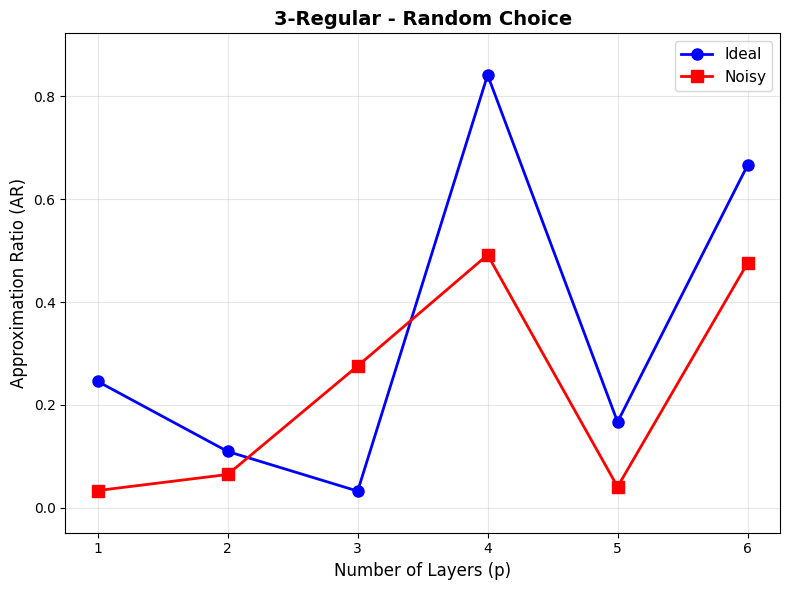

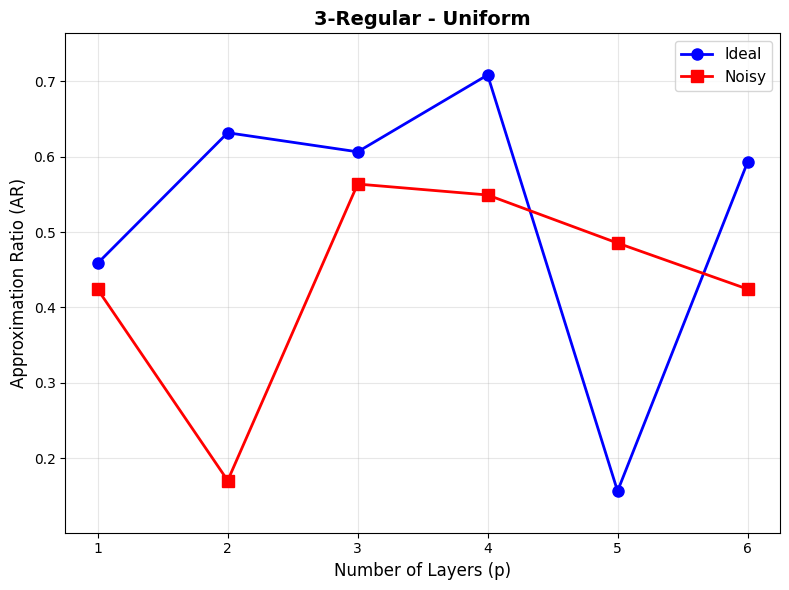

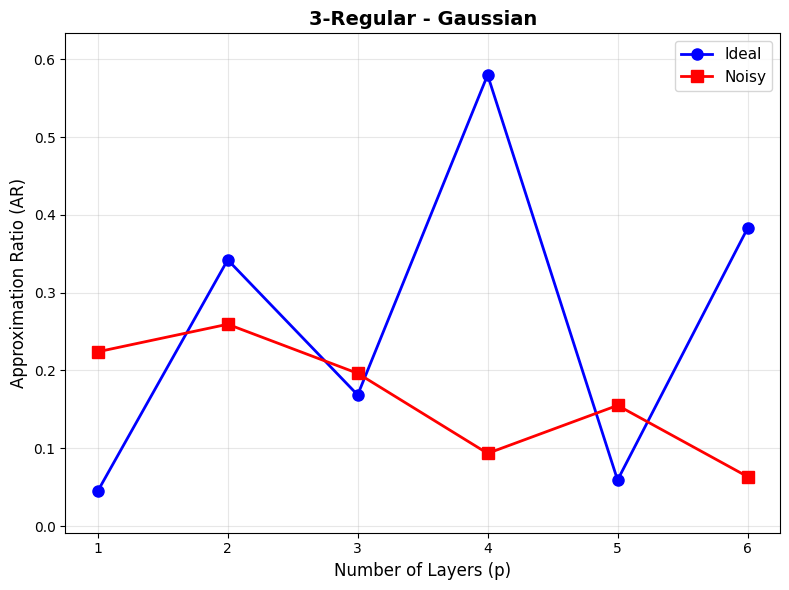

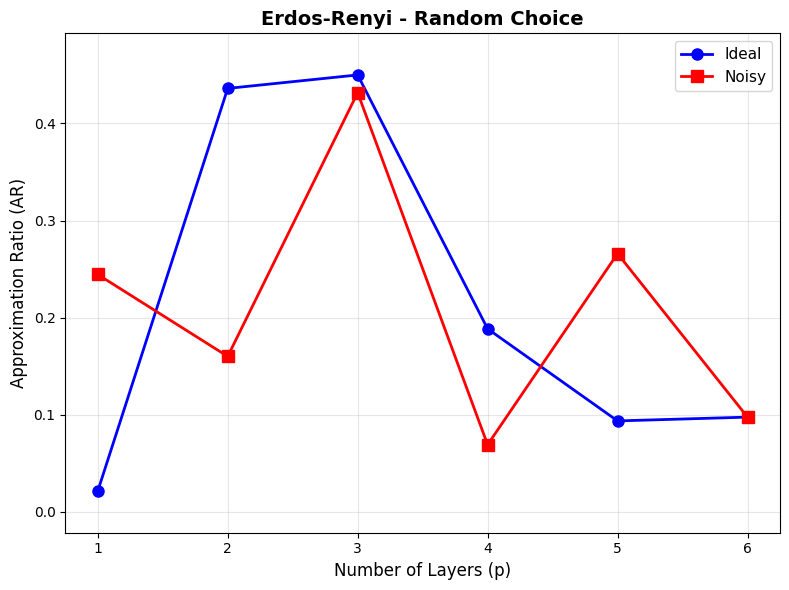

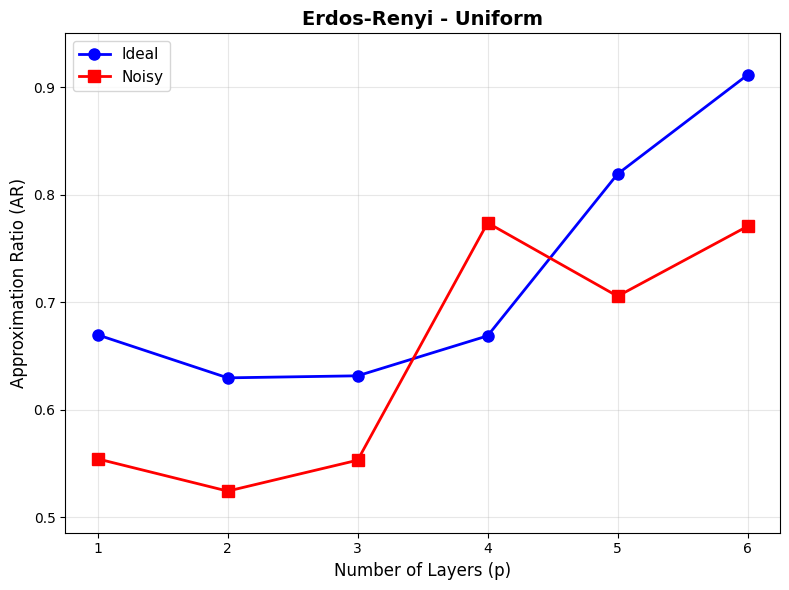

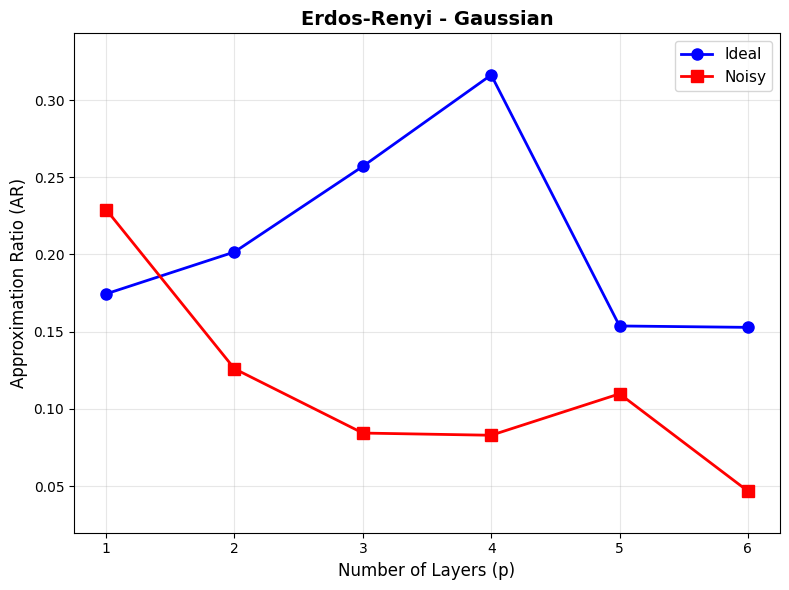

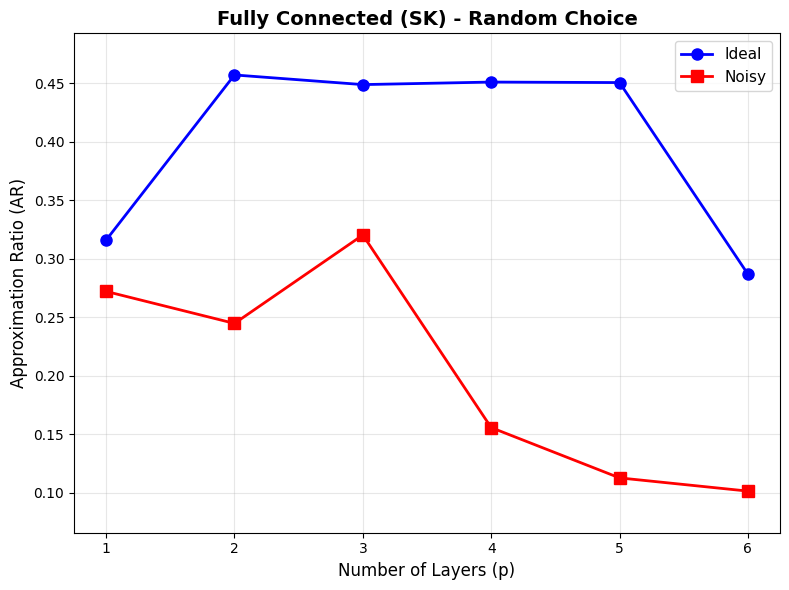

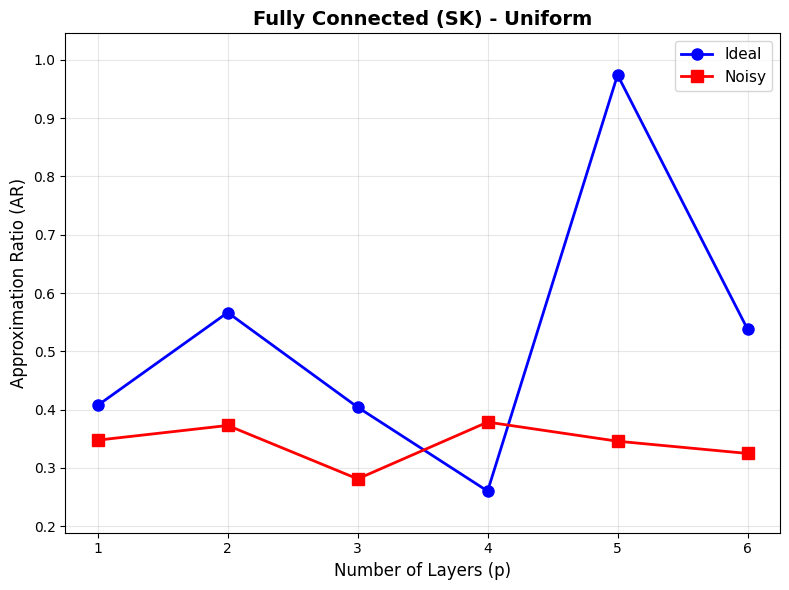

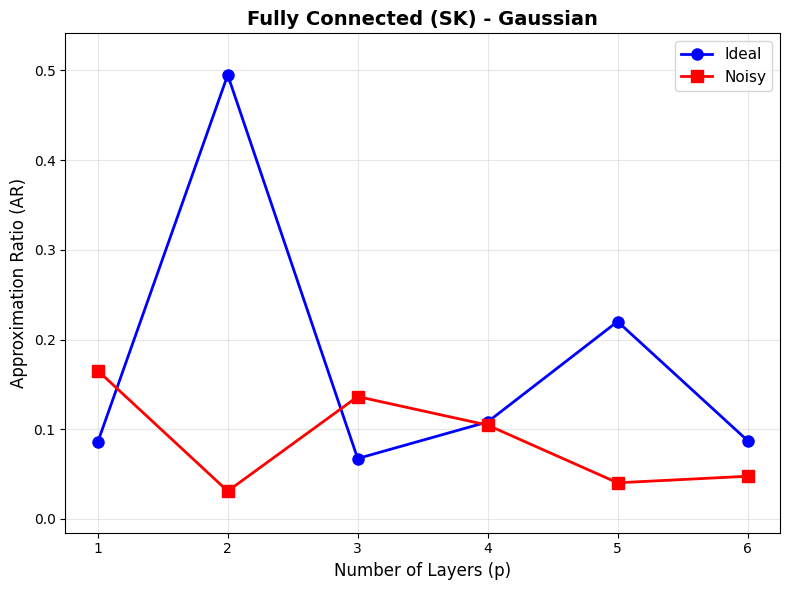

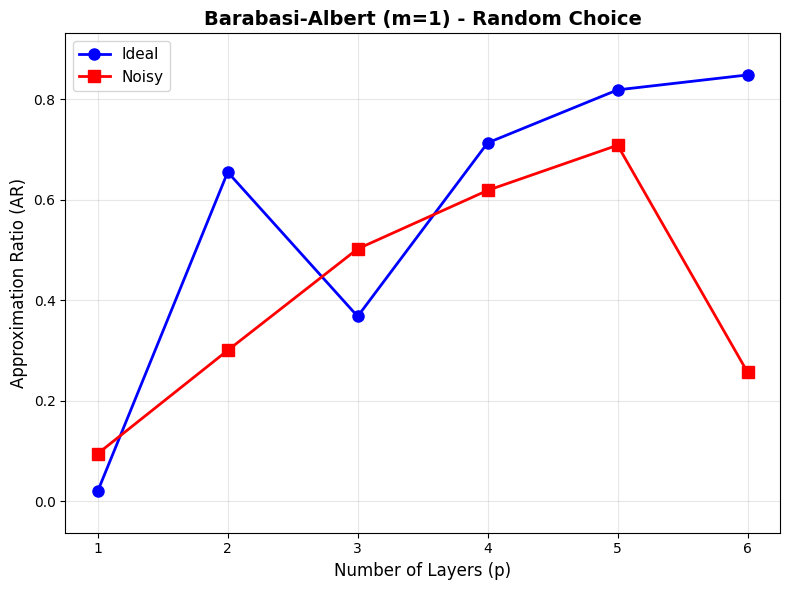

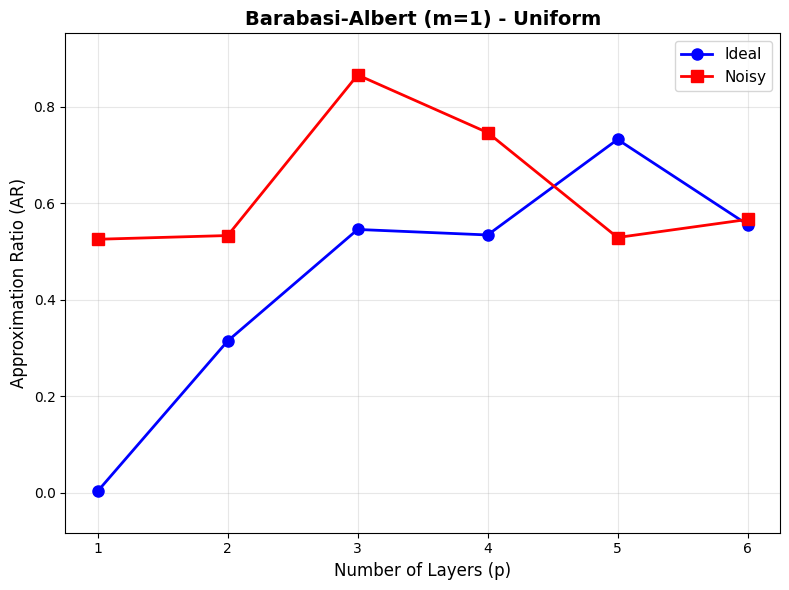

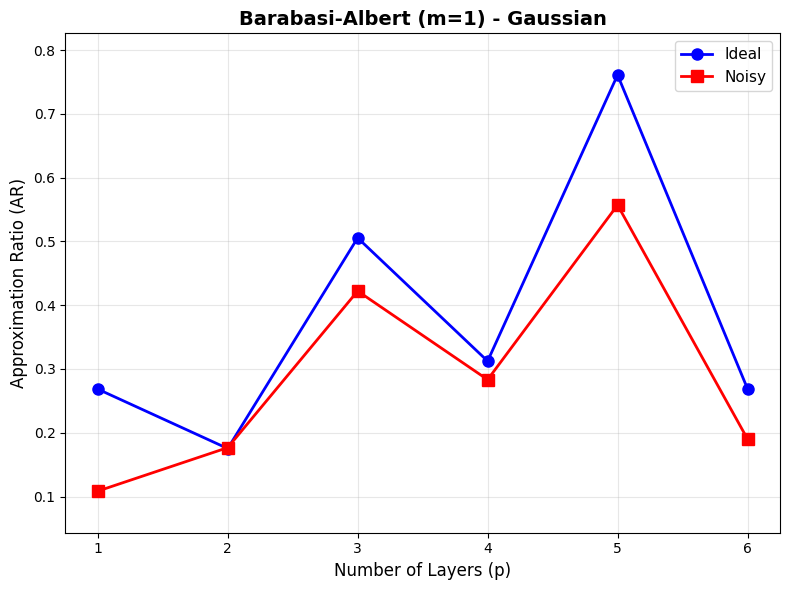


Part III Complete! All 12 figures generated.


In [36]:
# Part III: Create one figure per instance (12 figures total)
# Each figure shows AR vs p with both ideal and noisy curves

print("="*80)
print("PART III: Generating Plots")
print("="*80)

# Create a figure for each of the 12 instances
for topology in topologies:
    for weight_strategy in weight_strategies:
        key = f"{topology}_{weight_strategy}"
        
        # Skip if no results available
        if key not in results_ideal or len(results_ideal[key]['p']) == 0:
            print(f"Skipping plot for {key} (no results)")
            continue
        
        # Create figure for this instance
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Plot ideal results
        p_vals_ideal = results_ideal[key]['p']
        ar_vals_ideal = results_ideal[key]['ar']
        ax.plot(p_vals_ideal, ar_vals_ideal, marker='o', label='Ideal', 
                linewidth=2, markersize=8, color='blue')
        
        # Plot noisy results (if available)
        if backend is not None and key in results_noisy and len(results_noisy[key]['p']) > 0:
            p_vals_noisy = results_noisy[key]['p']
            ar_vals_noisy = results_noisy[key]['ar']
            ax.plot(p_vals_noisy, ar_vals_noisy, marker='s', label='Noisy', 
                    linewidth=2, markersize=8, color='red')
        
        # Formatting
        ax.set_xlabel('Number of Layers (p)', fontsize=12)
        ax.set_ylabel('Approximation Ratio (AR)', fontsize=12)
        
        # Create readable title
        topology_names = {
            '3regular': '3-Regular',
            'erdos_renyi': 'Erdos-Renyi',
            'fully_connected': 'Fully Connected (SK)',
            'barabasi_albert': 'Barabasi-Albert (m=1)'
        }
        weight_names = {
            'random_choice': 'Random Choice',
            'uniform': 'Uniform',
            'gaussian': 'Gaussian'
        }
        title = f"{topology_names.get(topology, topology)} - {weight_names.get(weight_strategy, weight_strategy)}"
        ax.set_title(title, fontsize=14, fontweight='bold')
        
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=11)
        
        # Set reasonable y-axis limits
        all_ar = ar_vals_ideal.copy()
        if backend is not None and key in results_noisy:
            all_ar.extend(results_noisy[key]['ar'])
        if len(all_ar) > 0:
            ar_min, ar_max = min(all_ar), max(all_ar)
            ar_range = ar_max - ar_min
            ax.set_ylim([ar_min - 0.1 * ar_range, ar_max + 0.1 * ar_range])
        
        plt.tight_layout()
        
        # Save figure
        # filename = f"AR_vs_p_{key}.png"
        # plt.savefig(filename, dpi=150, bbox_inches='tight')
        # print(f"Saved: {filename}")
        
        plt.show()
        
print("\n" + "="*80)
print("Part III Complete! All 12 figures generated.")
print("="*80)


### Summary and Quantitative Results

Summary table of all results.


In [33]:
# Print comprehensive summary table
print("\n" + "="*80)
print("QUANTITATIVE RESULTS SUMMARY")
print("="*80)
print(f"Problem size: n = {n}")
print(f"Layer sweep: p = {p_values}")
print("="*80)

topology_names = {
    '3regular': '3-Regular',
    'erdos_renyi': 'Erdos-Renyi',
    'fully_connected': 'Fully Connected (SK)',
    'barabasi_albert': 'Barabasi-Albert (m=1)'
}
weight_names = {
    'random_choice': 'Random Choice',
    'uniform': 'Uniform',
    'gaussian': 'Gaussian'
}

for topology in topologies:
    for weight_strategy in weight_strategies:
        key = f"{topology}_{weight_strategy}"
        print(f"\n{'='*80}")
        print(f"Instance: {topology_names.get(topology, topology)} - {weight_names.get(weight_strategy, weight_strategy)}")
        print(f"{'='*80}")
        
        if key in results_ideal and len(results_ideal[key]['p']) > 0:
            print("\nIdeal Simulation:")
            print(f"{'p':<6} {'AR':<12} {'Energy':<12}")
            print("-" * 30)
            for p, ar, energy in zip(results_ideal[key]['p'], 
                                     results_ideal[key]['ar'], 
                                     results_ideal[key]['energy']):
                print(f"{p:<6} {ar:<12.4f} {energy:<12.4f}")
        else:
            print("\nIdeal Simulation: No results")
        
        if backend is not None and key in results_noisy and len(results_noisy[key]['p']) > 0:
            print("\nNoisy Simulation:")
            print(f"{'p':<6} {'AR':<12} {'Energy':<12}")
            print("-" * 30)
            for p, ar, energy in zip(results_noisy[key]['p'], 
                                     results_noisy[key]['ar'], 
                                     results_noisy[key]['energy']):
                print(f"{p:<6} {ar:<12.4f} {energy:<12.4f}")
            if len(results_noisy[key]['p']) < len(p_values):
                print(f"\nNote: Noisy simulation stopped at p={results_noisy[key]['p'][-1]}")
        elif backend is not None:
            print("\nNoisy Simulation: No results (simulation may have stopped early)")

print("\n" + "="*80)
print("Summary Complete!")
print("="*80)



QUANTITATIVE RESULTS SUMMARY
Problem size: n = 6
Layer sweep: p = [1, 2, 3, 4, 5, 6]

Instance: 3-Regular - Random Choice

Ideal Simulation:
p      AR           Energy      
------------------------------
1      0.2455       -1.7188     
2      0.1094       -0.7656     
3      0.0324       -0.2266     
4      0.8415       -5.8906     
5      0.1669       -1.1680     
6      0.6657       -4.6602     

Noisy Simulation:
p      AR           Energy      
------------------------------
1      0.0335       -0.2344     
2      0.0647       -0.4531     
3      0.2757       -1.9297     
4      0.4916       -3.4414     
5      0.0407       -0.2852     
6      0.4754       -3.3281     

Instance: 3-Regular - Uniform

Ideal Simulation:
p      AR           Energy      
------------------------------
1      0.4587       -2.9954     
2      0.6318       -4.1253     
3      0.6065       -3.9601     
4      0.7085       -4.6262     
5      0.1562       -1.0199     
6      0.5925       -3.8689     

No